In [32]:
# Created on Sun Aug 13 13:14:06 2023

# @author: katelynsmith

import numpy as np # for maths 
import matplotlib # for plotting 
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams["font.family"] = "Times New Roman"
import matplotlib.pyplot as plt
from matplotlib import cm, ticker
#plt.style.use(['no-latex']) 
#from emcee import MASER
import glob
import os 
import pandas as pd

import astropy.units as u
from astropy.timeseries import BoxLeastSquares
from astropy.timeseries import LombScargle

import scipy.signal as sps

import maser as ms
import starspot as ss
import astrobase as ab
#from astrobase import periodbase


from tqdm import tqdm 
# Setting directory

ddir = '/Users/katelynsmith/Desktop/Capstone/'

import warnings
warnings.filterwarnings("ignore")

from scipy.optimize import curve_fit
import matplotlib.patches as patches
from scipy.signal import find_peaks

In [33]:
# Defining variables 
# Stuff for MASER

# Stellar parameters
M_s = 0.5 # Star mass (solar masses) 
R_s = 0.75 # Star radius (solar radii) 
P_s = 4.86 # Star rotation period (days) 
i_s = 90 # Star inclination of the rotation axis relative to the line of sight (degrees) 
B_s = 430 # Star dipole field strength at the magnetic poles (Gauss) 
beta = 20 # Star magnetic obliquity (degrees)
phi_s0 = 0.2 # Star rotation phase at times = 0 (0 – 1)

# Planet parameters
a = 10 # Planet orbital distance (stellar radii) #### REFERENCE 
i_p = 89.18 # Planet inclination of the orbital axis relative to the line of sight (degrees)
lam = 0 # Planet projected spin-orbit angle (degrees) 
phi_p0 = 0.6 # Planet orbital phase at times = 0 (0 – 1) 

# Emission parameters
f = 10 # Emission observing frequency (MHz) 
alpha = 75 # Emission cone opening angle (degrees) 
dalpha = 5 # Emission cone thickness (degrees)

# Extra stuff 
P_p = 8.4630351 # AU Mic b period (days)

In [34]:
# Defining useful functions
def get_events(t, vis):
    ups = np.where(np.diff(vis,1) > 0)[0]+1
    downs = np.where(np.diff(vis,1) < 0)[0]

    if ups[0] > downs[0]:
        downs = np.delete(downs,0)
    elif ups[-1] > downs [-1]:
        ups = np.delete(ups,-1)
    
    full_length = np.min([len(ups),len(downs)])
    ups, downs = ups[:full_length], downs[:full_length]

    durations = t[downs] - t[ups]
    centres = t[ups] + durations/2

    return centres, durations

def group_events(central_points):
    durations = np.diff(central_points)
    central_points = central_points[:-1] + durations/2

    return durations, central_points



In [35]:
times = np.linspace(0, 730, 40000) # Array of observation times to compute (days) - running for 2 years

# Calling MASER
visibility_North, visibility_South = ms.maser(M_s, R_s, P_s, i_s, B_s, beta, phi_s0, a, i_p, lam, phi_p0, f, alpha, dalpha, times)*1.0


In [5]:
ind_centres_S, ind_durations_S = get_events(times, visibility_South)
g_centres_S, g_durations_S = group_events(ind_centres_S)
minima_S = np.where(np.abs(g_centres_S - np.min(g_centres_S)) < 0.01)[0]
true_durations_S, timings_S = group_events(minima_S)

xs = g_durations_S 
ys = (g_centres_S/g_centres_S.max())

ind_centres_N, ind_durations_N = get_events(times, visibility_North)
g_centres_N, g_durations_N = group_events(ind_centres_N)
minima_N = np.where(np.abs(g_centres_N - np.min(g_centres_N)) < 0.01)[0]
true_durations_N, timings_N = group_events(minima_N)

xn = g_durations_N 
yn = (g_centres_N/g_centres_N.max())

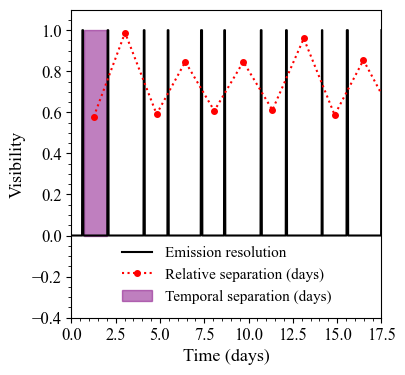

In [144]:
times = np.linspace(0, 730, 40000) # Array of observation times to compute (days) - running for 2 years

# Calling MASER
visibility_North, visibility_South = ms.maser(M_s, R_s, P_s, i_s, B_s, beta, phi_s0, a, i_p, lam, phi_p0, f, alpha, dalpha, times)*1.0

x1 = visibility_South[0]
x2 = visibility_South[1]
x = np.linspace(x1, x2, 100)
y = [1.0 for i in range(len(x))]


rect = plt.Rectangle((0.7, 0), 1.3, 1, 
                         edgecolor='purple', facecolor='purple', alpha=0.5, label='Temporal separation (days)')


fig = plt.figure(figsize=(4, 4))
plt.plot(times, visibility_South, 'k', label='Emission resolution')
plt.plot(xs,ys, 'ro:', markersize=4, label='Relative separation (days)')
plt.gca().add_patch(rect)
plt.xlabel('Time (days)', fontsize=13)
plt.ylabel('Visibility', fontsize=13)
plt.xlim(0,17.5)
plt.ylim(-0.4,1.1)
plt.legend(loc='lower center', framealpha=0, fontsize=11)
plt.minorticks_on()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


In [14]:
lower_curve_N = [yn[i] for i in range(0, len(yn),2)]
lower_times_N = [xn[i] for i in range(0, len(xn),2)]

lower_curve_S = [ys[i] for i in range(0, len(ys),2)]
lower_times_S = [xs[i] for i in range(0, len(xs),2)]

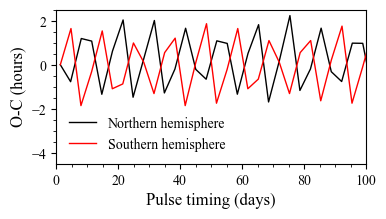

In [29]:
fig = plt.figure(figsize=(4, 2))

xn = g_durations_N 
yn = (g_centres_N/g_centres_N.max())
lower_times_N = [xn[i] for i in range(0, len(xn),2)]
mean_spacing_N = np.mean(np.diff(lower_times_N))

predicted_N = xn[0] + (mean_spacing_N)*np.arange(len(xn[::2]))
plt.plot(xn[::2], (xn[::2]-predicted_N)*24, 'k-', linewidth=1, label='Northern hemisphere')


xs = g_durations_S
ys = (g_centres_S/g_centres_S.max())
lower_times_S = [xs[i] for i in range(0, len(xs),2)]
mean_spacing_S = np.mean(np.diff(lower_times_S))

predicted_S = xs[0] + (mean_spacing_S)*np.arange(len(xs[::2]))
plt.plot(xs[::2], (xs[::2]-predicted_S)*24, 'r-', linewidth=1, label='Southern hemisphere')
plt.xlabel('Pulse timing (days)', fontsize=12)
plt.ylabel('O-C (hours)', fontsize=12)
plt.xlim(0,100)
plt.ylim(-4.5,2.5)
plt.legend(framealpha=0)
plt.minorticks_on()
plt.show()

In [ ]:

plt.rcParams["figure.figsize"] = [12, 5]
plt.rcParams["figure.autolayout"] = True
fig, ax1 = plt.subplots()
l, b, h, w = 0.125, 0.57, .35, .35
ax2 = fig.add_axes([l, b, w, h])
ax1.plot(np.log(1/set_frequency_N), np.log(power_N), 'k', lw=0.3)
ax1.set_xlabel('Natural logarithm of period (days)', fontsize=14)
ax1.set_ylabel('Natural logarithm of Lomb-Scargle power', fontsize=14)
ax2.scatter(lower_times_N % best_period_N, lower_curve_N, label='Data', color='k', s=1)
ax2.scatter(lower_times_N % best_period_N, pred_N, label=f'Fitted period = {best_period_N:.3f} d', color='r', s=3) 
ax2.set_xlabel('Time (days)', fontsize=14)
ax2.set_ylabel('Spacing (days)', fontsize=14)
ax1.set_ylim(-12.5, 12)
ax1.minorticks_on()
ax2.minorticks_on()
plt.show()

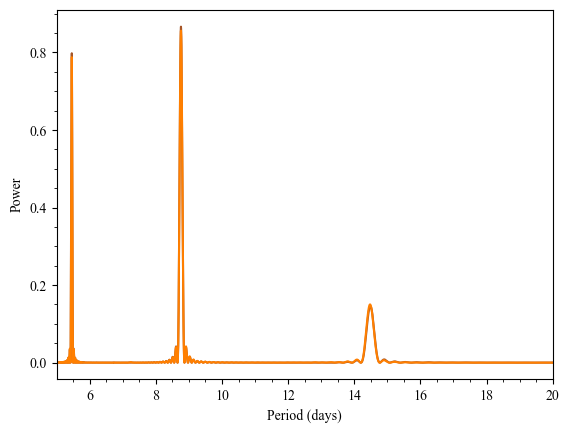

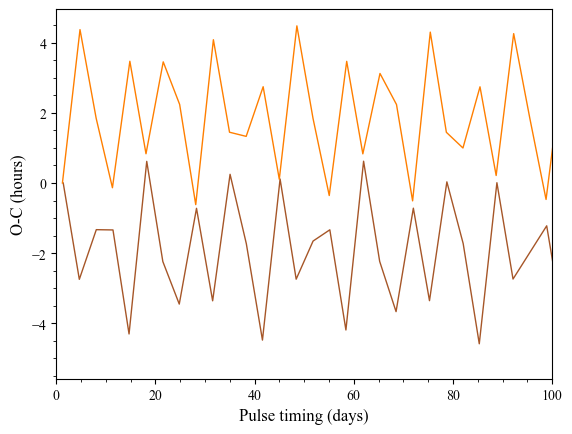

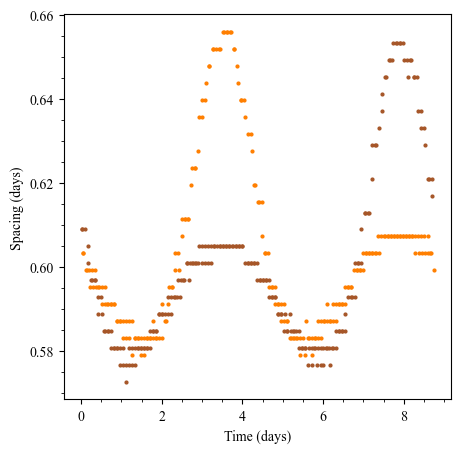

In [102]:
stellar_period = np.linspace(0.5*P_s, 4*P_s, 10)
frequencies = np.geomspace(1/20,1/5,10000)
period = 1/frequencies

s = 0.5*P_s

visibility_North, visibility_South = ms.maser(M_s, R_s, s, i_s, B_s, beta, phi_s0, a, i_p, lam, phi_p0, f, alpha, dalpha, times)*1.0


if np.count_nonzero(visibility_North) > 0:
    ind_centres_N, ind_durations_N = get_events(times, visibility_North)
    g_centres_N, g_durations_N = group_events(ind_centres_N)

    xn = g_durations_N 
    lower_times_N = [xn[i] for i in range(0, len(xn),2)]
    yn = (g_centres_N/g_centres_N.max())
    lower_curve_N = [yn[i] for i in range(0, len(yn),2)]

    mean_spacing_N = np.mean(np.diff(xn[::2]))

    predicted_N = xn[0] + (mean_spacing_N)*np.arange(len(xn[::2]))

    ominusc_n = xn[::2]-predicted_N

    ls_timing_n = LombScargle(xn[::2], ominusc_n)
    power_n = ls_timing_n.power(frequencies)
    best_period_n = period[np.argmax(power_n)]
else:
    mean_spacing_N = np.nan
    xn = np.nan
    predicted_N = np.nan
    power_n = np.nan
    best_period_n = np.nan
    lower_times_N = np.nan
    lower_curve_N = np.nan

if np.count_nonzero(visibility_South) > 0:
    ind_centres_S, ind_durations_S = get_events(times, visibility_South)
    g_centres_S, g_durations_S = group_events(ind_centres_S)

    xs = g_durations_S
    lower_times_S = [xs[i] for i in range(0, len(xs),2)]
    ys = (g_centres_S/g_centres_S.max())
    lower_curve_S = [ys[i] for i in range(0, len(ys),2)]

    mean_spacing_S = np.mean(np.diff(xs[::2]))

    predicted_S = xs[0] + (mean_spacing_S)*np.arange(len(xs[::2]))

    ominusc_s = xs[::2]-predicted_S

    ls_timing_s = LombScargle(xs[::2], ominusc_s)

    power_s = ls_timing_s.power(frequencies)
    best_period_s = period[np.argmax(power_s)]
else:
    mean_spacing_S = np.nan
    lower_times_S = np.nan
    xs = np.nan
    predicted_S = np.nan
    power_s = np.nan
    best_period_s = np.nan
    lower_curve_S = np.nan


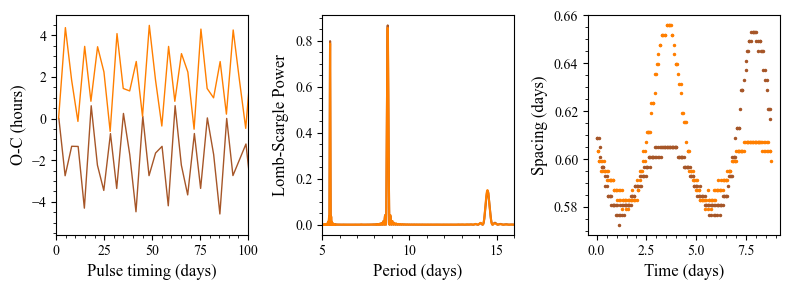

In [114]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(8, 3))

CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

    
ax2.plot(period, power_n, c=CB_color_cycle[4])
ax2.plot(period, power_s, c=CB_color_cycle[1])
ax2.set_xlim(5, 16)
ax2.set_xlabel('Period (days)', fontsize=12)
ax2.set_ylabel('Lomb-Scargle Power', fontsize=12)
ax2.minorticks_on()

ax1.plot(xn[::2], (xn[::2]-predicted_N)*24, '-', c=CB_color_cycle[4], linewidth=1, label='Northern hemisphere')
ax1.plot(xs[::2], (xs[::2]-predicted_S)*24, '-', c=CB_color_cycle[1], linewidth=1, label='Southern hemisphere')
ax1.set_xlabel('Pulse timing (days)', fontsize=12)
ax1.set_ylabel('O-C (hours)', fontsize=12)
ax1.set_xlim(0,100)
ax1.minorticks_on()

ax3.plot(xn[::2] % best_period_n, lower_curve_N, '.', c=CB_color_cycle[4], markersize=3)
ax3.plot(xs[::2] % best_period_s, lower_curve_S, '.', c=CB_color_cycle[1], markersize=3)
ax3.set_xlabel('Time (days)', fontsize=12)
ax3.set_ylabel('Spacing (days)', fontsize=12)
ax3.minorticks_on()
fig.tight_layout()
plt.show()

In [68]:
stellar_period = np.linspace(0.5*P_s, 4*P_s, 10)
frequencies = np.geomspace(1/20,1/5,10000)
period = 1/frequencies

s = 0.5*P_s

visibility_North, visibility_South = ms.maser(M_s, R_s, s, i_s, B_s, beta, phi_s0, a, i_p, lam, phi_p0, f, alpha, dalpha, times)*1.0



if np.count_nonzero(visibility_North) > 0:
    ind_centres_N, ind_durations_N = get_events(times, visibility_North)
    g_centres_N, g_durations_N = group_events(ind_centres_N)

    xn = g_durations_N 
    yn = (g_centres_N/g_centres_N.max())

    mean_spacing_N = np.mean(np.diff(xn[::2]))

    predicted_N = xn[0] + (mean_spacing_N)*np.arange(len(xn[::2]))

    ominusc_n = xn[::2]-predicted_N
    ls_timing_n = LombScargle(xn[::2], ominusc_n)
    power_n = ls_timing_n.power(frequencies)
    best_period_n = period[np.argmax(power_n)]
else:
    mean_spacing_N = np.nan
    xn = np.nan
    predicted_N = np.nan
    power_n = np.nan
    best_period_n = np.nan

if np.count_nonzero(visibility_South) > 0:
    ind_centres_S, ind_durations_S = get_events(times, visibility_South)
    g_centres_S, g_durations_S = group_events(ind_centres_S)

    xs = g_durations_S
    ys = (g_centres_S/g_centres_S.max())

    mean_spacing_S = np.mean(np.diff(xs[::2]))

    predicted_S = xs[0] + (mean_spacing_S)*np.arange(len(xs[::2]))
    ominusc_s = xs[::2]-predicted_S
    ls_timing_s = LombScargle(xs[::2], ominusc_s)
    power_s = ls_timing_s.power(frequencies)
    best_period_s = period[np.argmax(power_s)]
else:
    mean_spacing_S = np.nan
    xs = np.nan
    predicted_S = np.nan
    power_s = np.nan
    best_period_s = np.nan
    
    
    plt.plot(xn[::2] % best_period_n,ominusc_n*24, 'ko')
    plt.plot(xs[::2] % best_period_s,ominusc_s*24, 'ro')
    plt.xlabel('Phase (d)')
    plt.ylabel('O-C (h)')
    plt.title('Timing Residuals: Period = {0:.2f} d'.format(best_period_s, best_period_n))
    plt.show()



In [81]:
def LS_periods(M_s, R_s, stellar_period, i_s, B_s, beta, phi_s0, a, i_p, lam, phi_p0, f, alpha, dalpha, times, frequencies, period):
    visibility_North, visibility_South = ms.maser(M_s, R_s, stellar_period, i_s, B_s, beta, phi_s0, a, i_p, lam, phi_p0, f, alpha, dalpha, times)*1.0

    if np.count_nonzero(visibility_North) > 0:
        ind_centres_N, ind_durations_N = get_events(times, visibility_North)
        g_centres_N, g_durations_N = group_events(ind_centres_N)

        xn = g_durations_N 

        mean_spacing_N = np.mean(np.diff(xn[::2]))
        mean_second_spacing_N = np.mean(np.diff(xn[::2],2))

        predicted_N = xn[0] + (mean_spacing_N)*np.arange(len(xn[::2]))

        ominusc_n = xn[::2]-predicted_N
        ls_timing_n = LombScargle(xn[::2], ominusc_n)
        power_n = ls_timing_n.power(frequencies)
        best_period_n = period[np.argmax(power_n)]
    else:
        mean_spacing_N = np.nan
        mean_second_spacing_N = np.nan
        best_period_n = np.nan

    if np.count_nonzero(visibility_South) > 0:
        ind_centres_S, ind_durations_S = get_events(times, visibility_South)
        g_centres_S, g_durations_S = group_events(ind_centres_S)

        xs = g_durations_S

        mean_spacing_S = np.mean(np.diff(xs[::2]))
        mean_second_spacing_S = np.mean(np.diff(xs[::2],2))

        predicted_S = xs[0] + (mean_spacing_S)*np.arange(len(xs[::2]))
        ominusc_s = xs[::2]-predicted_S
        ls_timing_s = LombScargle(xs[::2], ominusc_s)
        power_s = ls_timing_s.power(frequencies)
        best_period_s = period[np.argmax(power_s)]
    else:
        mean_spacing_S = np.nan
        best_period_s = np.nan
        mean_second_spacing_S = np.nan
    
    return mean_spacing_N, mean_spacing_S, best_period_n, best_period_s, mean_second_spacing_N, mean_second_spacing_S



In [122]:
stellar_period = np.linspace(0.5*P_s, 4*P_s, 100)
frequencies = np.geomspace(1/20,1/5,10000)
period = 1/frequencies

synodic_periods = []
mean_north_spacing = []
mean_south_spacing = []
mean_second_north_spacing = []
mean_second_south_spacing = []
best_north_period = []
best_south_period = [] 

for s in tqdm(stellar_period):
    mean_spacing_N, mean_spacing_S, best_period_n, best_period_s, mean_second_spacing_N, mean_second_spacing_S = LS_periods(M_s, R_s, s, i_s, B_s, beta, phi_s0, a, i_p, lam, phi_p0, f, alpha, dalpha, times, frequencies, period)
    
    synodic_p = 1/(1/s - 1/P_p)
    synodic_periods.append(synodic_p)
    mean_north_spacing.append(mean_spacing_N)
    mean_south_spacing.append(mean_spacing_S)
    mean_second_north_spacing.append(mean_second_spacing_N)
    mean_second_south_spacing.append(mean_second_spacing_S)
    best_north_period.append(best_period_n)
    best_south_period.append(best_period_s)


100%|██████████| 100/100 [09:35<00:00,  5.76s/it]


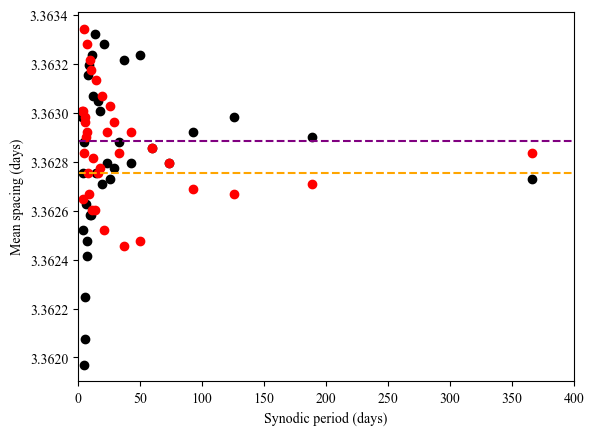

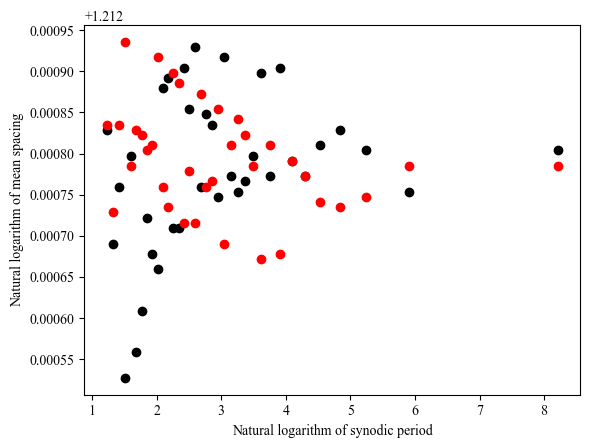

In [124]:
plt.plot(synodic_periods, mean_north_spacing, 'ko')
plt.plot(synodic_periods, mean_south_spacing, 'ro')
plt.ylabel('Mean spacing (days)')
plt.xlabel('Synodic period (days)')
plt.axhline(np.mean(mean_north_spacing), color='purple', linestyle='--')
plt.axhline(np.mean(mean_south_spacing), color='orange', linestyle='--')
plt.xlim(0,400)
plt.show()

plt.plot(np.log(synodic_periods), np.log(mean_north_spacing), 'ko')
plt.plot(np.log(synodic_periods), np.log(mean_south_spacing), 'ro')
plt.ylabel('Natural logarithm of mean spacing')
plt.xlabel('Natural logarithm of synodic period')
plt.show()

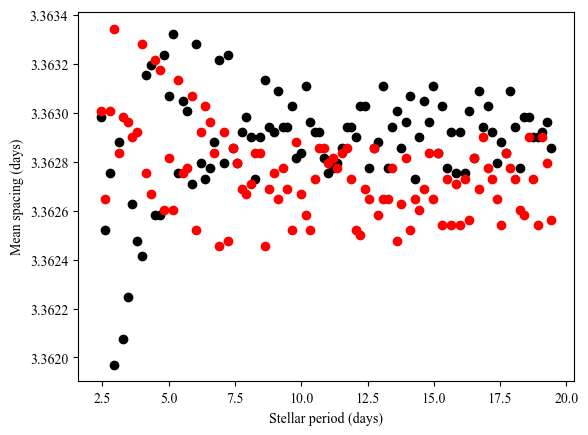

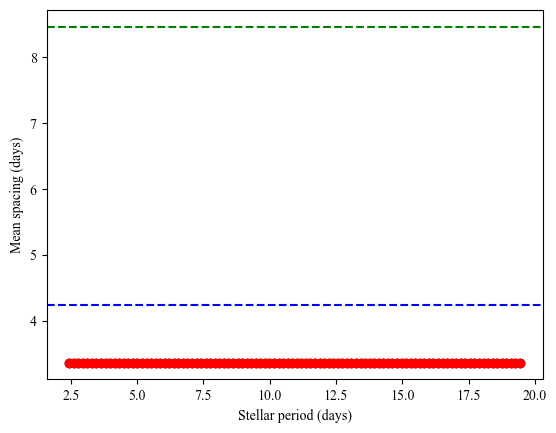

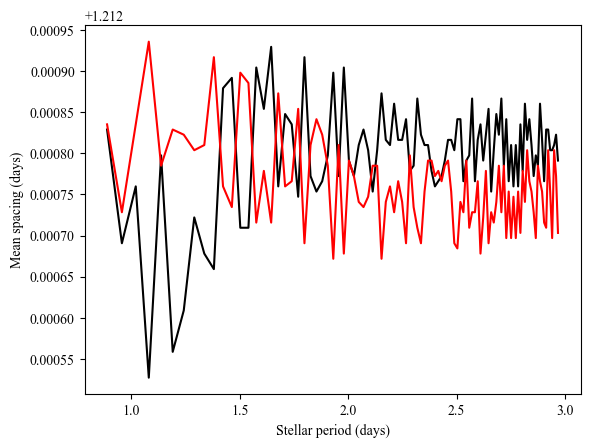

In [130]:

plt.plot(stellar_period, mean_north_spacing, 'ko')
plt.plot(stellar_period, mean_south_spacing, 'ro')
#plt.axhline(np.mean(mean_north_spacing), color='purple', linestyle='--')
#plt.axhline(np.mean(mean_south_spacing), color='orange', linestyle='--')
#plt.axhline(P_p, color='green', linestyle='--')
plt.ylabel('Mean spacing (days)')
plt.xlabel('Stellar period (days)')
plt.show()

plt.plot(stellar_period, mean_north_spacing, 'ko')
plt.plot(stellar_period, mean_south_spacing, 'ro')
# plt.axhline(np.mean(mean_north_spacing), color='purple', linestyle='--')
# plt.axhline(np.mean(mean_south_spacing), color='orange', linestyle='--')
plt.axhline(P_p, color='green', linestyle='--')
plt.axhline(P_p/2, color='blue', linestyle='--')
plt.ylabel('Mean spacing (days)')
plt.xlabel('Stellar period (days)')
plt.show()

plt.plot(np.log(stellar_period), np.log(mean_north_spacing), 'k-')
plt.plot(np.log(stellar_period), np.log(mean_south_spacing), 'r-')
plt.ylabel('Mean spacing (days)')
plt.xlabel('Stellar period (days)')
plt.show()

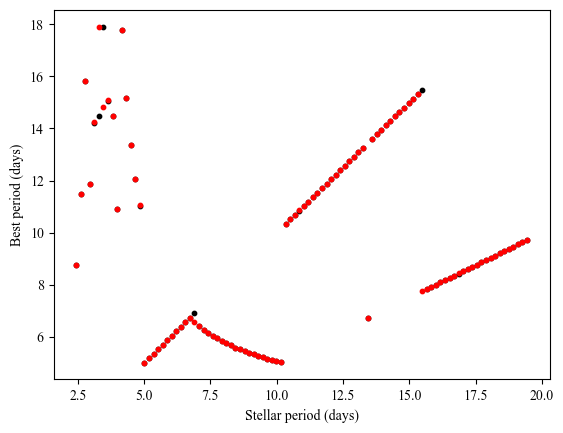

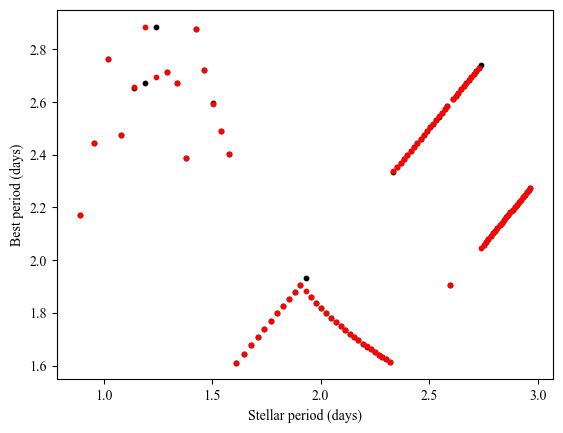

In [107]:
plt.scatter(stellar_period, best_north_period, color='k', s=10)
plt.scatter(stellar_period, best_south_period, color='r', s=10)
plt.ylabel('Best period (days)')
plt.xlabel('Stellar period (days)')
plt.show()


plt.scatter(np.log(stellar_period), np.log(best_north_period), color='k', s=10)
plt.scatter(np.log(stellar_period), np.log(best_south_period), color='r', s=10)
plt.ylabel('Best period (days)')
plt.xlabel('Stellar period (days)')
plt.show()


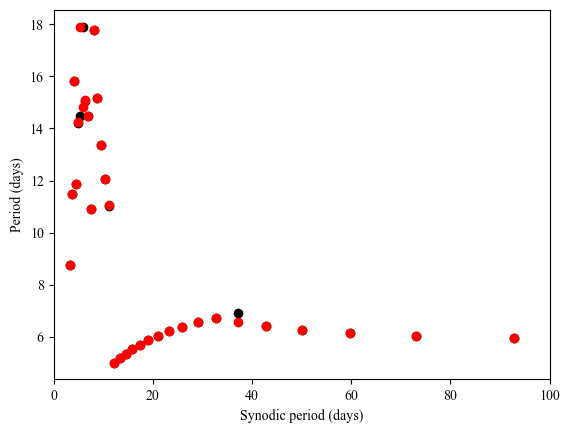

In [91]:
plt.plot(synodic_periods, best_north_period, 'ko')
plt.plot(synodic_periods, best_south_period, 'ro')
plt.ylabel('Period (days)')
plt.xlabel('Synodic period (days)')
plt.xlim(0,100)
plt.show()


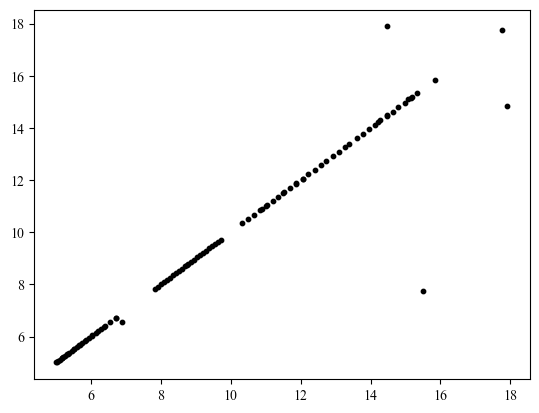

In [76]:
plt.scatter(best_north_period, best_south_period, color='k', s=10)
plt.show()

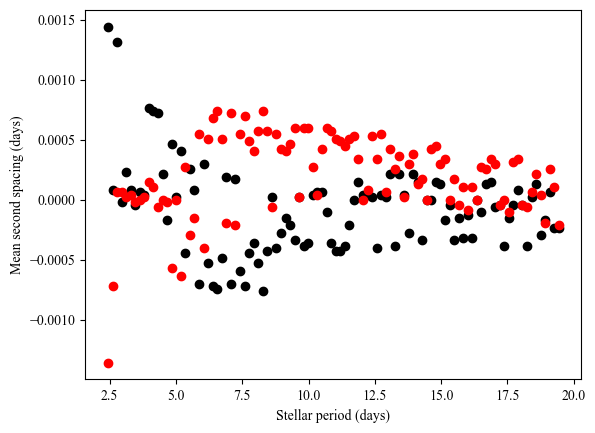

In [93]:
plt.plot(stellar_period, mean_second_north_spacing, 'ko')
plt.plot(stellar_period, mean_second_south_spacing, 'ro')
plt.ylabel('Mean second spacing (days)')
plt.xlabel('Stellar period (days)')
plt.show()

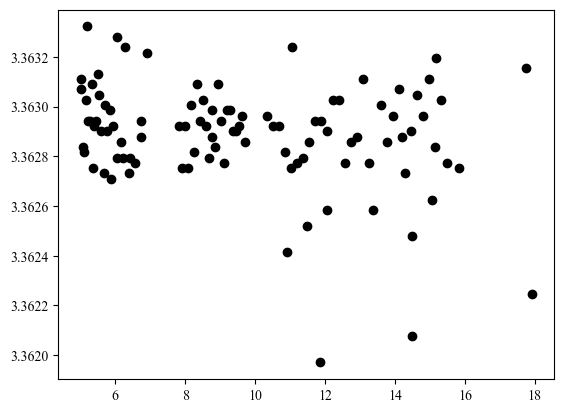

In [120]:
plt.plot(best_north_period, mean_north_spacing, 'ko')
plt.show()

In [140]:
def LS_periods(M_s, R_s, stellar_period, i_s, B_s, beta, phi_s0, semi_major_axis, i_p, lam, phi_p0, f, alpha, dalpha, times, frequencies, period):
    visibility_North, visibility_South = ms.maser(M_s, R_s, stellar_period, i_s, B_s, beta, phi_s0, semi_major_axis, i_p, lam, phi_p0, f, alpha, dalpha, times)*1.0
    
    sec_per_day = 86400
    Msun = 1.989e33
    Rsun = 6.955e10
    G = 6.674e-8
    planetary_period = 2*np.pi * ((semi_major_axis * R_s * Rsun) ** 3 / (G * M_s * Msun)) ** 0.5 / sec_per_day 

    synodic_period = 1/(1/stellar_period - 1/planetary_period)

    if np.count_nonzero(visibility_North) > 0:
        ind_centres_N, ind_durations_N = get_events(times, visibility_North)
        g_centres_N, g_durations_N = group_events(ind_centres_N)

        xn = g_durations_N 

        mean_spacing_N = np.mean(np.diff(xn[::2]))
        mean_second_spacing_N = np.mean(np.diff(xn[::2],2))

        predicted_N = xn[0] + (mean_spacing_N)*np.arange(len(xn[::2]))

        ominusc_n = xn[::2]-predicted_N
        ls_timing_n = LombScargle(xn[::2], ominusc_n)
        power_n = ls_timing_n.power(frequencies)
        best_period_n = period[np.argmax(power_n)]

        sorted_power_N = np.sort(power_n)
        reverse_power_N = sorted_power_N[::-1]

        A1_N_power = reverse_power_N[0].item()
        A2_N_power = reverse_power_N[1].item()
        A3_N_power = reverse_power_N[2].item()

        A1_N_frequency = frequencies[np.where(power_n == A1_N_power)].item()
        A2_N_frequency = frequencies[np.where(power_n == A2_N_power)].item()
        A3_N_frequency = frequencies[np.where(power_n == A3_N_power)].item()
    else:
        mean_spacing_N = np.nan
        mean_second_spacing_N = np.nan
        best_period_n = np.nan
        A1_N_frequency = np.nan
        A2_N_frequency = np.nan
        A3_N_frequency = np.nan

    if np.count_nonzero(visibility_South) > 0:
        ind_centres_S, ind_durations_S = get_events(times, visibility_South)
        g_centres_S, g_durations_S = group_events(ind_centres_S)

        xs = g_durations_S

        mean_spacing_S = np.mean(np.diff(xs[::2]))
        mean_second_spacing_S = np.mean(np.diff(xs[::2],2))

        predicted_S = xs[0] + (mean_spacing_S)*np.arange(len(xs[::2]))
        ominusc_s = xs[::2]-predicted_S
        ls_timing_s = LombScargle(xs[::2], ominusc_s)
        power_s = ls_timing_s.power(frequencies)
        best_period_s = period[np.argmax(power_s)]

        sorted_power_S = np.sort(power_s)
        reverse_power_S = sorted_power_S[::-1]

        A1_S_power = reverse_power_S[0].item()
        A2_S_power = reverse_power_S[1].item()
        A3_S_power = reverse_power_S[2].item()

        A1_S_frequency = frequencies[np.where(power_s == A1_S_power)].item()
        A2_S_frequency = frequencies[np.where(power_s == A2_S_power)].item()
        A3_S_frequency = frequencies[np.where(power_s == A3_S_power)].item()
    else:
        mean_spacing_S = np.nan
        best_period_s = np.nan
        mean_second_spacing_S = np.nan
        A1_S_frequency = np.nan
        A2_S_frequency = np.nan
        A3_S_frequency = np.nan
    
    return planetary_period, synodic_period, mean_spacing_N, mean_spacing_S, best_period_n, best_period_s, mean_second_spacing_N, mean_second_spacing_S, A1_N_frequency, A2_N_frequency, A3_N_frequency, A1_S_frequency, A2_S_frequency, A3_S_frequency

In [239]:
stellar_period = np.linspace(0.5*P_s, 4*P_s, 50)
semi_major_axis = np.linspace(0.5*a, 4*a, 50)
frequencies = np.geomspace(1/20,1/5,10000)
period = 1/frequencies


# Required parameters for the planetary period
sec_per_day = 86400
Msun = 1.989e33
Rsun = 6.955e10
G = 6.674e-8

planetary_period = [2*np.pi * ((sma * R_s * Rsun) ** 3 / (G * M_s * Msun)) ** 0.5 / sec_per_day for sma in semi_major_axis]


50

In [143]:
planetary_period_grid = np.zeros((len(stellar_period), len(semi_major_axis), 1))
synodic_grid = np.zeros((len(stellar_period), len(planetary_period), 1))
mean_spacing_grid = np.zeros((len(stellar_period), len(planetary_period), 2))
mean_second_spacing_grid = np.zeros((len(stellar_period), len(planetary_period), 2))
best_period_grid = np.zeros((len(stellar_period), len(planetary_period), 2))
frequency_1_grid = np.zeros((len(stellar_period), len(planetary_period), 2))
frequency_2_grid = np.zeros((len(stellar_period), len(planetary_period), 2))
frequency_3_grid = np.zeros((len(stellar_period), len(planetary_period), 2))

for ind, s in enumerate(tqdm(stellar_period)):
    for jind, sma in enumerate(semi_major_axis):
        planetary_period, synodic_period, mean_spacing_N, mean_spacing_S, best_period_n, best_period_s, mean_second_spacing_N, mean_second_spacing_S, A1_N_frequency, A2_N_frequency, A3_N_frequency, A1_S_frequency, A2_S_frequency, A3_S_frequency = LS_periods(M_s, R_s, s, i_s, B_s, beta, phi_s0, sma, i_p, lam, phi_p0, f, alpha, dalpha, times, frequencies, period)
        
        planetary_period_grid[ind, jind, :] = planetary_period
        synodic_grid[ind, jind, :] = synodic_period
        mean_spacing_grid[ind, jind, :] = mean_spacing_N, mean_spacing_S
        mean_second_spacing_grid[ind, jind, :] = mean_second_spacing_N, mean_second_spacing_S
        best_period_grid[ind, jind, :] = best_period_n, best_period_s
        frequency_1_grid[ind, jind, :] = A1_N_frequency, A1_S_frequency
        frequency_2_grid[ind, jind, :] = A2_N_frequency, A2_S_frequency
        frequency_3_grid[ind, jind, :] = A3_N_frequency, A3_S_frequency




100%|██████████| 50/50 [3:37:15<00:00, 260.71s/it]  


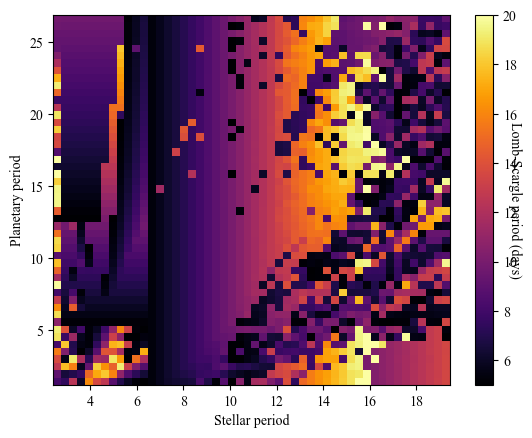

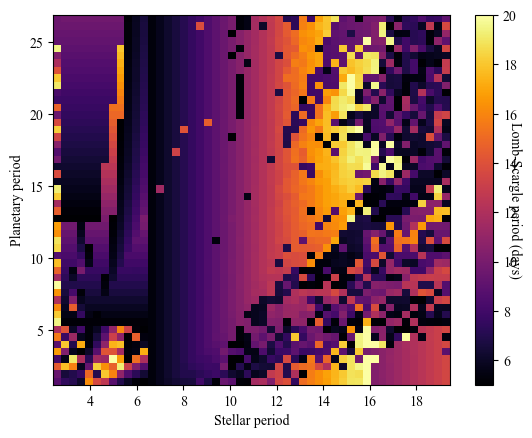

In [159]:
plt.imshow(best_period_grid[:,:,0], origin='lower', extent=[0.5*P_s, 4*P_s, 1.1889490222538108, 26.902845315865115], aspect='auto', interpolation='none', cmap=cm.inferno)
cbar = plt.colorbar()
cbar.set_label('Lomb-Scargle period (days)', rotation=270)
plt.xlabel('Stellar period')
plt.ylabel('Planetary period')
plt.show()

plt.imshow(best_period_grid[:,:,1], origin='lower', extent=[0.5*P_s, 4*P_s, 1.1889490222538108, 26.902845315865115], aspect='auto', interpolation='none', cmap=cm.inferno)
cbar = plt.colorbar()
cbar.set_label('Lomb-Scargle period (days)', rotation=270)
plt.xlabel('Stellar period')
plt.ylabel('Planetary period')
plt.show()

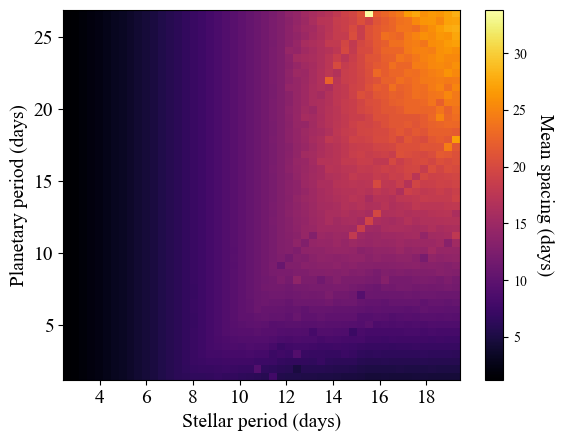

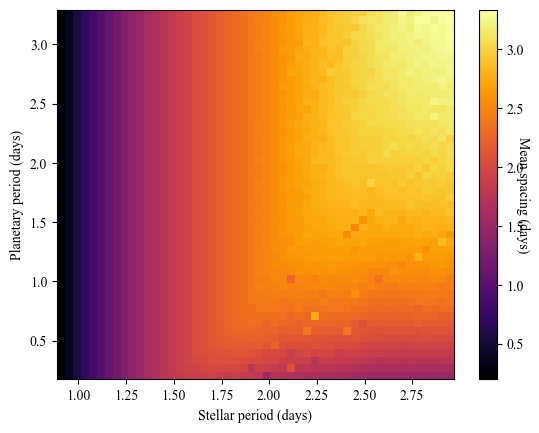

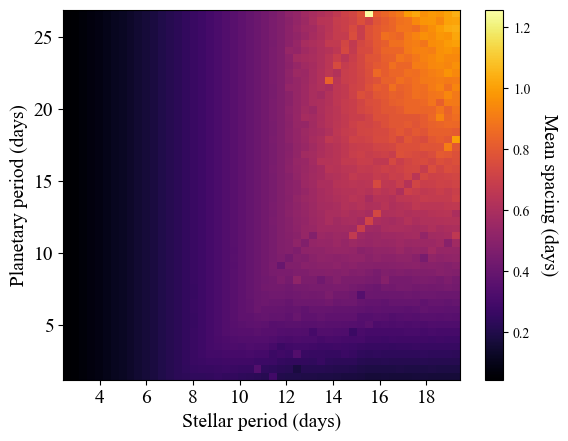

In [568]:
plt.imshow(mean_spacing_grid[:,:,0], origin='lower', extent=[0.5*P_s, 4*P_s, 1.1889490222538108, 26.902845315865115], aspect='auto', interpolation='none', cmap=cm.inferno)
cbar = plt.colorbar()
cbar.set_label('Mean spacing (days)', rotation=270, labelpad=20, fontsize=14)
plt.xlabel('Stellar period (days)', fontsize=14)
plt.ylabel('Planetary period (days)', fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.show()



plt.imshow(np.log(mean_spacing_grid[:,:,1]), origin='lower', extent=[np.log(0.5*P_s), np.log(4*P_s), np.log(1.1889490222538108), np.log(26.902845315865115)], aspect='auto', interpolation='none', cmap=cm.inferno)
cbar = plt.colorbar()
cbar.set_label('Mean spacing (days)', rotation=270)
plt.xlabel('Stellar period (days)')
plt.ylabel('Planetary period (days)')
plt.show()


stellar_period = np.linspace(0.5*P_s, 4*P_s, 50)
semi_major_axis = np.linspace(0.5*a, 4*a, 50)
frequencies = np.geomspace(1/20,1/5,10000)
period = 1/frequencies


# Required parameters for the planetary period
sec_per_day = 86400
Msun = 1.989e33
Rsun = 6.955e10
G = 6.674e-8

planetary_period = [2*np.pi * ((sma * R_s * Rsun) ** 3 / (G * M_s * Msun)) ** 0.5 / sec_per_day for sma in semi_major_axis]

for p in planetary_period:
    stuff = mean_spacing_grid[:,:,0]/p

plt.imshow(stuff, origin='lower', extent=[0.5*P_s, 4*P_s, 1.1889490222538108, 26.902845315865115], aspect='auto', interpolation='none', cmap=cm.inferno)
cbar = plt.colorbar()
cbar.set_label('Mean spacing (days)', rotation=270, labelpad=20, fontsize=14)
plt.xlabel('Stellar period (days)', fontsize=14)
plt.ylabel('Planetary period (days)', fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


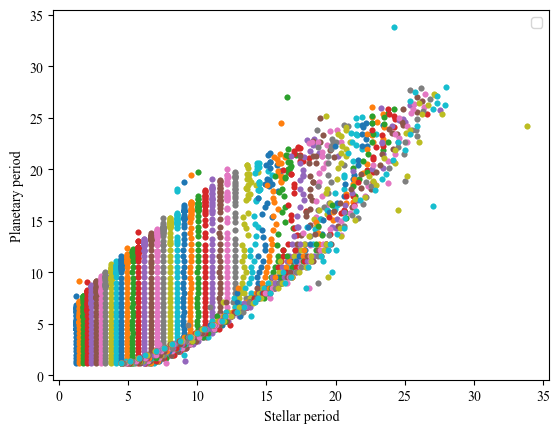

In [217]:
for i in range(0, len(stellar_period)):
    plt.scatter(mean_spacing_grid[:,i,0], mean_spacing_grid[i,:,0], s=10)
plt.xlabel('Stellar period')
plt.ylabel('Planetary period')
plt.legend()
plt.show()




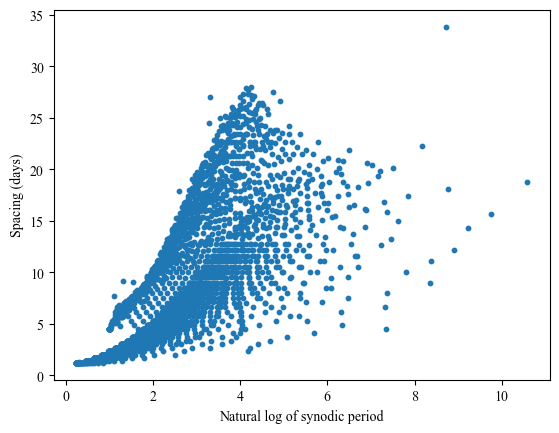

In [195]:
plt.scatter(np.log(np.abs(synodic_grid[:,:,0])), mean_spacing_grid[:,:,0], s=10)
plt.xlabel('Natural log of synodic period')
plt.ylabel('Spacing (days)')
plt.show()


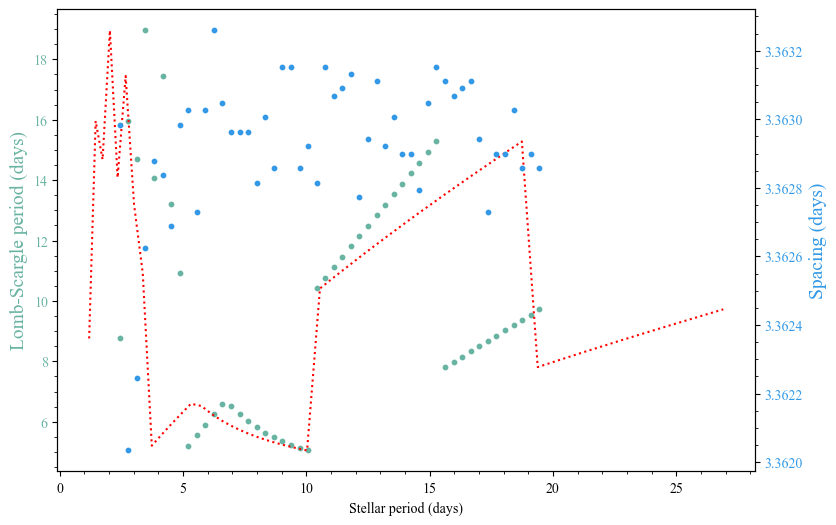

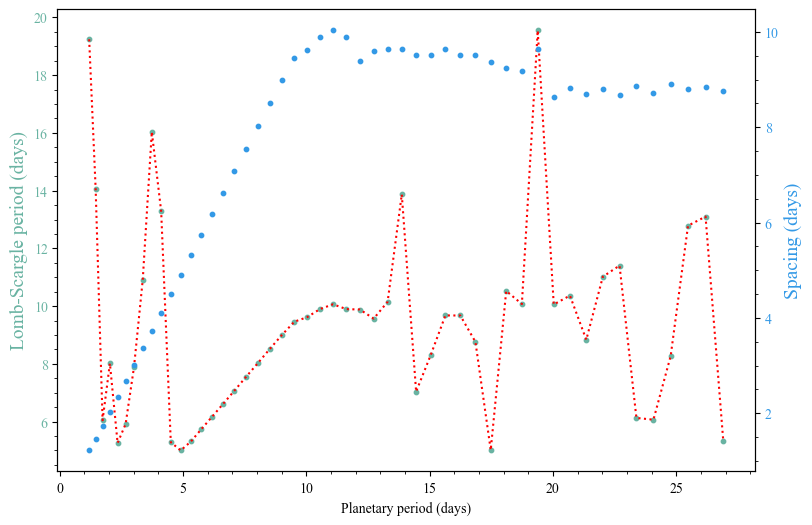

In [512]:
fig, ax1 = plt.subplots(figsize=(9, 6))

COLOR_PERIOD = "#69b3a2"
COLOR_SPACING = "#3399e6"


ax2 = ax1.twinx()
ax1.scatter(stellar_period, best_period_grid[:,7,0], s=10, color=COLOR_PERIOD)
ax2.scatter(stellar_period, mean_spacing_grid[:,7,0], s=10, color=COLOR_SPACING)
ax1.plot(planetary_period, 1/frequency_1_grid[:,7,0], 'r:')



ax1.set_xlabel("Stellar period (days)")
ax1.set_ylabel("Lomb-Scargle period (days)", color=COLOR_PERIOD, fontsize=14)
ax1.tick_params(axis="y", labelcolor=COLOR_PERIOD)
ax2.set_ylabel("Spacing (days)", color=COLOR_SPACING, fontsize=14)
ax2.tick_params(axis="y", labelcolor=COLOR_SPACING)
ax1.minorticks_on()
ax2.minorticks_on()

plt.show()

stellar_period = np.linspace(0.5*P_s, 4*P_s, 50)
semi_major_axis = np.linspace(0.5*a, 4*a, 50)
frequencies = np.geomspace(1/20,1/5,10000)
period = 1/frequencies


# Required parameters for the planetary period
sec_per_day = 86400
Msun = 1.989e33
Rsun = 6.955e10
G = 6.674e-8

planetary_period = [2*np.pi * ((sma * R_s * Rsun) ** 3 / (G * M_s * Msun)) ** 0.5 / sec_per_day for sma in semi_major_axis]


fig, ax1 = plt.subplots(figsize=(9, 6))

COLOR_PERIOD = "#69b3a2"
COLOR_SPACING = "#3399e6"


ax2 = ax1.twinx()
ax1.scatter(planetary_period, best_period_grid[7,:,0], s=10, color=COLOR_PERIOD)
ax2.scatter(planetary_period, mean_spacing_grid[7,:,0], s=10, color=COLOR_SPACING)
ax1.plot(planetary_period, 1/frequency_3_grid[7,:,0], 'r:')

ax1.set_xlabel("Planetary period (days)")
ax1.set_ylabel("Lomb-Scargle period (days)", color=COLOR_PERIOD, fontsize=14)
ax1.tick_params(axis="y", labelcolor=COLOR_PERIOD)
ax2.set_ylabel("Spacing (days)", color=COLOR_SPACING, fontsize=14)
ax2.tick_params(axis="y", labelcolor=COLOR_SPACING)
ax1.minorticks_on()
ax2.minorticks_on()

plt.show()

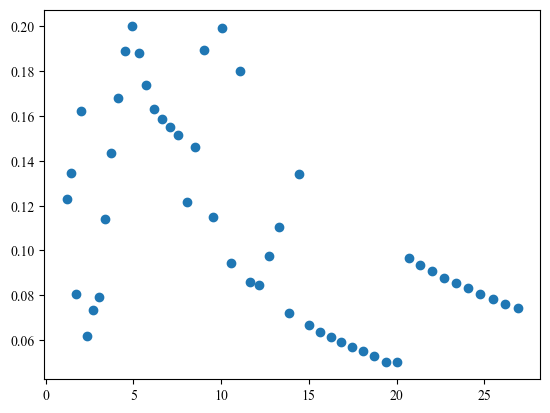

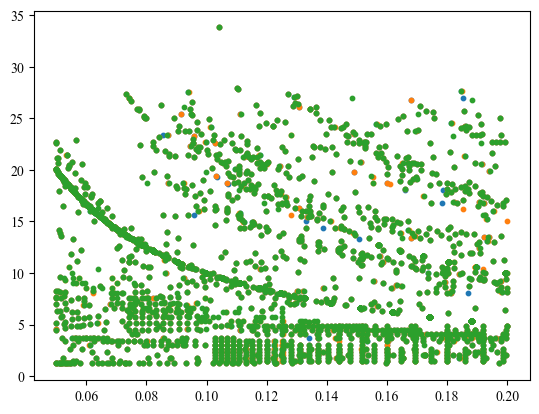

In [254]:
plt.scatter(planetary_period, frequency_1_grid[0,:,0])
plt.show()

plt.scatter(frequency_1_grid[:,:,0], mean_spacing_grid[:,:,0], s=10)
plt.scatter(frequency_2_grid[:,:,0], mean_spacing_grid[:,:,0], s=10)
plt.scatter(frequency_3_grid[:,:,0], mean_spacing_grid[:,:,0], s=10)
plt.show()

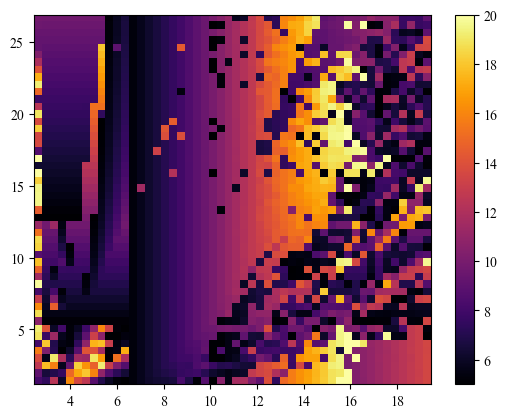

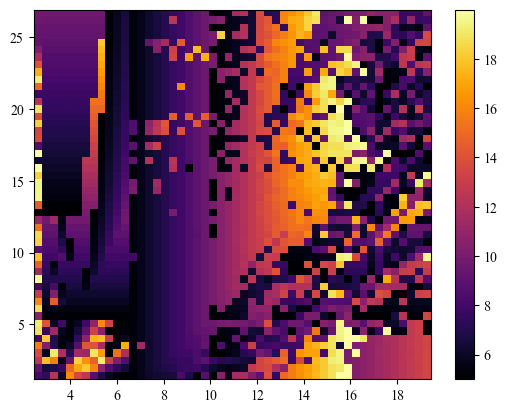

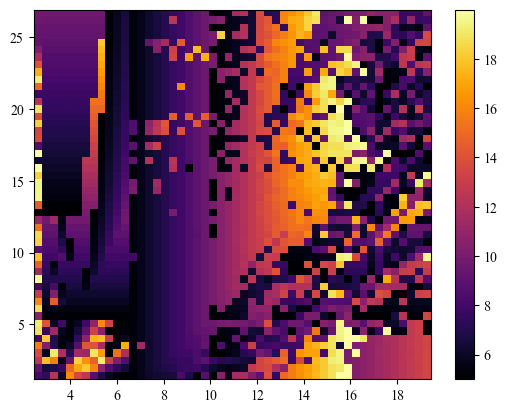

In [250]:
plt.imshow(1/frequency_1_grid[:,:,0], origin='lower', extent=[0.5*P_s, 4*P_s, 1.1889490222538108, 26.902845315865115], aspect='auto', interpolation='none', cmap=cm.inferno)
cbar = plt.colorbar()
plt.show()

plt.imshow(1/frequency_2_grid[:,:,0], origin='lower', extent=[0.5*P_s, 4*P_s, 1.1889490222538108, 26.902845315865115], aspect='auto', interpolation='none', cmap=cm.inferno)
cbar = plt.colorbar()
plt.show()

plt.imshow(1/frequency_2_grid[:,:,0], origin='lower', extent=[0.5*P_s, 4*P_s, 1.1889490222538108, 26.902845315865115], aspect='auto', interpolation='none', cmap=cm.inferno)
cbar = plt.colorbar()
plt.show()

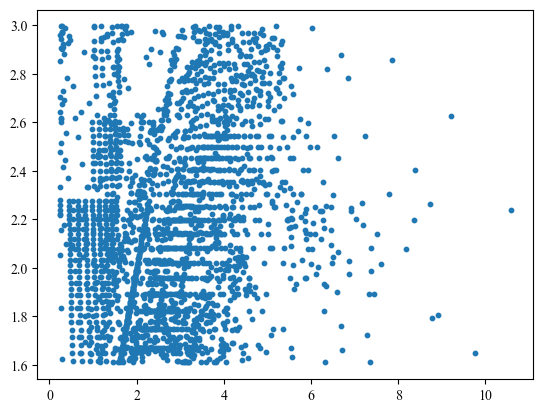

In [278]:
plt.scatter(np.log(np.abs(synodic_grid[:,:,0])), np.log(best_period_grid[:,:,0]), s=10)
plt.show()

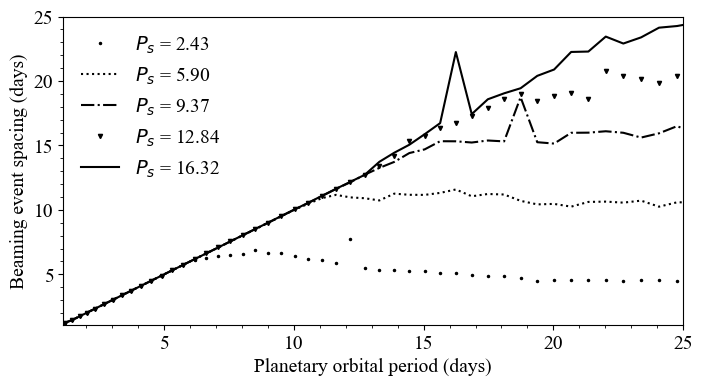

In [456]:


color = ["pink", "g", "b", "k", "b", "#FF7256", "k", "c", "y", "o", "#6495ED", "g", "b", "o", "b", "orange", "k", "c", "y", "o", "#8470FF", "g", "b", "r", "b", "#33A1C9", "k", "c", "y", "o", "#D02090", "g", "b", "r", "b", "#808069", "k", "c", "y", "o", "#27408B", "g", "b", "r", "b", "#8B3626", "k", "c", "y", "o"]
labels = ["$P_s$ = 2.43", "g", "b", "k", "b", "$P_s$ = 4.17", "k", "c", "y", "o", "$P_s$ = 5.90", "g", "b", "o", "b", "$P_s$ = 7.64", "k", "c", "y", "o", "$P_s$ = 9.37", "g", "b", "r", "b", "$P_s$ = 11.11", "k", "c", "y", "o", "$P_s$ = 12.84", "g", "b", "r", "b", "$P_s$ = 14.58", "k", "c", "y", "o", "$P_s$ = 16.32", "g", "b", "r", "b", "$P_s$ = 18.05", "k", "c", "y", "o"]
marker = [".", "g", "b", "k", "b", "#FF7256", "k", "c", "y", "o", ":", "g", "b", "o", "b", "orange", "k", "c", "y", "o", "-.", "g", "b", "r", "b", "#33A1C9", "k", "c", "y", "o", "v", "g", "b", "r", "b", "#808069", "k", "c", "y", "o", "#27408B", "g", "b", "r", "b", "#8B3626", "k", "c", "y", "o"]

plt.figure(figsize=(8,4))

for i in range(0,50,10):
    plt.plot(planetary_period, mean_spacing_grid[i,:,0], marker[i], c='k', markersize=3, label=labels[i])
plt.xlabel('Planetary orbital period (days)', fontsize=14)
plt.ylabel('Beaming event spacing (days)', fontsize=14)
plt.minorticks_on()
plt.legend(framealpha=0, fontsize=14)
plt.ylim(1.1,25)
plt.xlim(1.1,25)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14) 
plt.show()



In [459]:
test_pp = planetary_period[23]
test_ps = stellar_period[0]
test_a =  (G*M_s*Msun*(test_pp*sec_per_day)**2/(4*np.pi**2))**(1/3) / (R_s*Rsun)


good_pp = planetary_period[10]
good_ps = stellar_period[0]
good_a =  (G*M_s*Msun*(good_pp*sec_per_day)**2/(4*np.pi**2))**(1/3) / (R_s*Rsun)

visN, visS = ms.maser(M_s, R_s, good_ps, i_s, B_s, beta, phi_s0, good_a, i_p, lam, phi_p0, f, alpha, dalpha, times)


visN2, visS2 = ms.maser(M_s, R_s, test_ps, i_s, B_s, beta, phi_s0, test_a, i_p, lam, phi_p0, f, alpha, dalpha, times)


In [464]:
visN, visS = ms.maser(M_s, R_s, good_ps, i_s, B_s, beta, phi_s0, good_a, i_p, lam, phi_p0, f, alpha, dalpha, times)


visN2, visS2 = ms.maser(M_s, R_s, test_ps, i_s, B_s, beta, phi_s0, test_a, i_p, lam, phi_p0, f, alpha, dalpha, times)


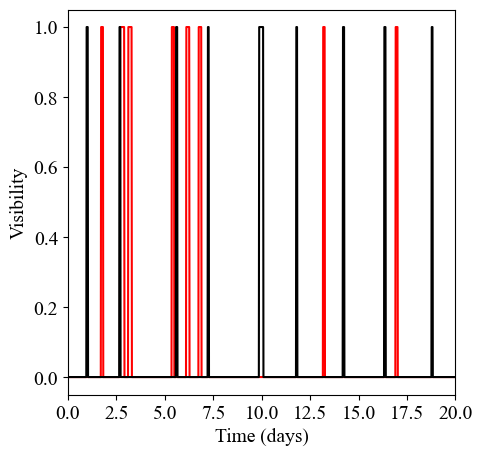

In [478]:
plt.figure(figsize=(5,5))
plt.plot(times, visN2, 'r')
plt.plot(times, visN, 'k')
plt.xlabel('Time (days)', fontsize=14)
plt.ylabel('Visibility', fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlim(0,20)
plt.show()



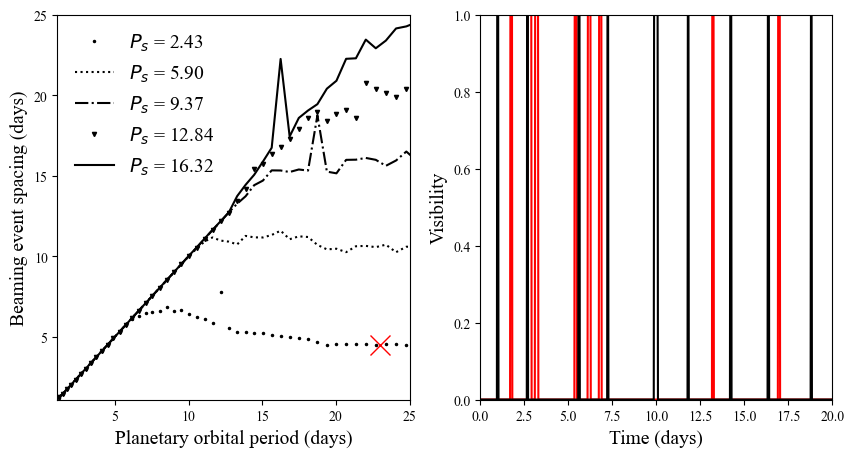

In [493]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
for i in range(0,50,10):
    ax1.plot(planetary_period, mean_spacing_grid[i,:,0], marker[i], c='k', markersize=3, label=labels[i])
ax1.set_xlabel('Planetary orbital period (days)', fontsize=14)
ax1.plot(23, mean_spacing_grid[23,10,0], marker='x', c='r', markersize=15)
ax1.set_ylabel('Beaming event spacing (days)', fontsize=14)
#ax1.minorticks_on()
ax1.legend(framealpha=0, fontsize=14)
ax1.set_ylim(1.1,25)
ax1.set_xlim(1.1,25)
ax2.plot(times, visN2, 'r')
ax2.plot(times, visN, 'k')
ax2.set_xlabel('Time (days)', fontsize=14)
ax2.set_ylabel('Visibility', fontsize=14)
# ax1.set_yticks(fontsize=14)
# ax1.set_xticks(fontsize=14)
# ax2.set_yticks(fontsize=14)
# ax2.set_xticks(fontsize=14)
ax2.set_xlim(0,20)
ax2.set_ylim(0,1)
#ax2.minorticks_on()
plt.show()


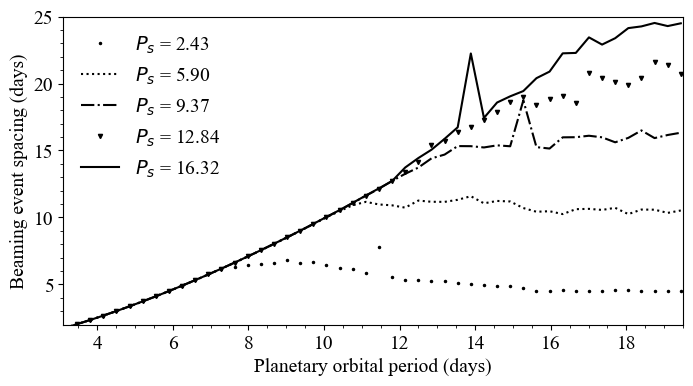

In [477]:
color = ["pink", "g", "b", "k", "b", "#FF7256", "k", "c", "y", "o", "#6495ED", "g", "b", "o", "b", "orange", "k", "c", "y", "o", "#8470FF", "g", "b", "r", "b", "#33A1C9", "k", "c", "y", "o", "#D02090", "g", "b", "r", "b", "#808069", "k", "c", "y", "o", "#27408B", "g", "b", "r", "b", "#8B3626", "k", "c", "y", "o"]
labels = ["$P_s$ = 2.43", "g", "b", "k", "b", "$P_s$ = 4.17", "k", "c", "y", "o", "$P_s$ = 5.90", "g", "b", "o", "b", "$P_s$ = 7.64", "k", "c", "y", "o", "$P_s$ = 9.37", "g", "b", "r", "b", "$P_s$ = 11.11", "k", "c", "y", "o", "$P_s$ = 12.84", "g", "b", "r", "b", "$P_s$ = 14.58", "k", "c", "y", "o", "$P_s$ = 16.32", "g", "b", "r", "b", "$P_s$ = 18.05", "k", "c", "y", "o"]
marker = [".", "g", "b", "k", "b", "#FF7256", "k", "c", "y", "o", ":", "g", "b", "o", "b", "orange", "k", "c", "y", "o", "-.", "g", "b", "r", "b", "#33A1C9", "k", "c", "y", "o", "v", "g", "b", "r", "b", "#808069", "k", "c", "y", "o", "#27408B", "g", "b", "r", "b", "#8B3626", "k", "c", "y", "o"]

plt.figure(figsize=(8,4))

for i in range(0,50,10):
    plt.plot(stellar_period, mean_spacing_grid[i,:,0], marker[i], c='k', markersize=3, label=labels[i])
plt.xlabel('Planetary orbital period (days)', fontsize=14)
plt.ylabel('Beaming event spacing (days)', fontsize=14)
plt.minorticks_on()
plt.legend(framealpha=0, fontsize=14)
plt.ylim(2,25)
plt.xlim(3.1,19.5)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.show()

In [42]:
def LS_periods(M_s, R_s, stellar_period, i_s, B_s, beta, phi_s0, semi_major_axis, i_p, lam, phi_p0, f, alpha, dalpha, times, frequencies, period):
    visibility_North, visibility_South = ms.maser(M_s, R_s, stellar_period, i_s, B_s, beta, phi_s0, semi_major_axis, i_p, lam, phi_p0, f, alpha, dalpha, times)*1.0
    
    sec_per_day = 86400
    Msun = 1.989e33
    Rsun = 6.955e10
    G = 6.674e-8
    planetary_period = 2*np.pi * ((semi_major_axis * R_s * Rsun) ** 3 / (G * M_s * Msun)) ** 0.5 / sec_per_day 

    synodic_period = 1/(1/stellar_period - 1/planetary_period)

    if np.count_nonzero(visibility_North) > 0:
        ind_centres_N, ind_durations_N = get_events(times, visibility_North)
        g_centres_N, g_durations_N = group_events(ind_centres_N)

        xn = g_durations_N 

        mean_spacing_N = np.mean(np.diff(xn[::2]))
        mean_second_spacing_N = np.mean(np.diff(xn[::2],2))

        predicted_N = xn[0] + (mean_spacing_N)*np.arange(len(xn[::2]))

        ominusc_n = xn[::2]-predicted_N
        ls_timing_n = LombScargle(xn[::2], ominusc_n)
        power_n = ls_timing_n.power(frequencies)
        best_period_n = period[np.argmax(power_n)]

        peaksN, metadataN = find_peaks(power_n,prominence=0.01)
        order_n = np.argsort(metadataN['prominences'])[::-1]
        top_3_n = frequencies[peaksN][order_n][:3]

        if len(top_3_n) == 0:
            peak_val_1N = np.nan
            peak_val_2N = np.nan
            peak_val_3N = np.nan
            second_best_period_n = np.nan
            third_best_period_n = np.nan
        elif len(top_3_n) == 1:
            peak_val_1N = power_n[peaksN][0]
            peak_val_2N = np.nan
            peak_val_3N = np.nan
            second_best_period_n = np.nan
            third_best_period_n = np.nan
        elif len(top_3_n) == 2:
            peak_val_1N = power_n[peaksN][0]
            peak_val_2N = power_n[peaksN][1]
            peak_val_3N = np.nan
            second_best_period_n = top_3_n[1]
            third_best_period_n = np.nan
        else:
            peak_val_1N = power_n[peaksN][0]
            peak_val_2N = power_n[peaksN][1]
            peak_val_3N = power_n[peaksN][2]
            second_best_period_n = top_3_n[1]
            third_best_period_n = top_3_n[2]
    else:
        peak_val_1N = np.nan
        peak_val_2N = np.nan
        peak_val_3N = np.nan
        mean_spacing_N = np.nan
        mean_second_spacing_N = np.nan
        best_period_n = np.nan
        top_3_n = np.nan
        second_best_period_n = np.nan
        third_best_period_n = np.nan

    if np.count_nonzero(visibility_South) > 0:
        ind_centres_S, ind_durations_S = get_events(times, visibility_South)
        g_centres_S, g_durations_S = group_events(ind_centres_S)

        xs = g_durations_S

        mean_spacing_S = np.mean(np.diff(xs[::2]))
        mean_second_spacing_S = np.mean(np.diff(xs[::2],2))

        predicted_S = xs[0] + (mean_spacing_S)*np.arange(len(xs[::2]))
        ominusc_s = xs[::2]-predicted_S
        ls_timing_s = LombScargle(xs[::2], ominusc_s)
        power_s = ls_timing_s.power(frequencies)
        best_period_s = period[np.argmax(power_s)]

        peaksS, metadataS = find_peaks(power_s,prominence=0.01)
        order_s = np.argsort(metadataS['prominences'])[::-1]
        top_3_s = frequencies[peaksS][order_s][:3]
        if len(top_3_s) == 0:
            peak_val_1S = np.nan
            peak_val_2S = np.nan
            peak_val_3S = np.nan
            second_best_period_s = np.nan
            third_best_period_s = np.nan
        elif len(top_3_s) == 1:
            peak_val_1S = power_s[peaksS][0]
            peak_val_2S = np.nan
            peak_val_3S = np.nan
            second_best_period_s = np.nan
            third_best_period_s = np.nan
        elif len(top_3_s) == 2:
            peak_val_1S = power_s[peaksS][0]
            peak_val_2S = power_s[peaksS][1]
            peak_val_3S = np.nan
            second_best_period_s = top_3_s[1]
            third_best_period_s = np.nan
        else:
            peak_val_1S = power_s[peaksS][0]
            peak_val_2S = power_s[peaksS][1]
            peak_val_3S = power_s[peaksS][2]
            second_best_period_s = top_3_s[1]
            third_best_period_s = top_3_s[2]
    else:
        peak_val_1S = np.nan
        peak_val_2S = np.nan
        peak_val_3S = np.nan
        mean_spacing_S = np.nan
        best_period_s = np.nan
        mean_second_spacing_S = np.nan
        top_3_s = np.nan
        second_best_period_s = np.nan
        third_best_period_s = np.nan
    
    return planetary_period, synodic_period, mean_spacing_N, mean_spacing_S, best_period_n, best_period_s, mean_second_spacing_N, mean_second_spacing_S, second_best_period_n, second_best_period_s, third_best_period_n, third_best_period_s, peak_val_1N, peak_val_1S, peak_val_2N, peak_val_2S, peak_val_3N, peak_val_3S

In [40]:
# Stellar parameters
M_s = 0.5 # Star mass (solar masses) 
R_s = 0.75 # Star radius (solar radii) 
P_s = 4.86 # Star rotation period (days) 
i_s = 90 # Star inclination of the rotation axis relative to the line of sight (degrees) 
B_s = 430 # Star dipole field strength at the magnetic poles (Gauss) 
beta = 20 # Star magnetic obliquity (degrees)
phi_s0 = 0.2 # Star rotation phase at times = 0 (0 – 1)

# Planet parameters
a = 10 # Planet orbital distance (stellar radii) #### REFERENCE 
i_p = 89.18 # Planet inclination of the orbital axis relative to the line of sight (degrees)
lam = 0 # Planet projected spin-orbit angle (degrees) 
phi_p0 = 0.6 # Planet orbital phase at times = 0 (0 – 1) 

# Emission parameters
f = 10 # Emission observing frequency (MHz) 
alpha = 75 # Emission cone opening angle (degrees) 
dalpha = 5 # Emission cone thickness (degrees)

# Extra stuff 
#P_p = 8.4630351 # AU Mic b period (days)


frequencies = np.geomspace(1/20,1/5,10000)
period = 1/frequencies


# Required parameters for the planetary period
sec_per_day = 86400
Msun = 1.989e33
Rsun = 6.955e10
G = 6.674e-8

times = np.linspace(0, 730, 40000)



In [115]:
stellar_period = np.linspace(0.5*P_s, 4*P_s, 50)
semi_major_axis = np.linspace(0.5*a, 4*a, 50)
pp = [2*np.pi * ((sma * R_s * Rsun) ** 3 / (G * M_s * Msun)) ** 0.5 / sec_per_day for sma in semi_major_axis]

planetary_period_grid_2 = np.zeros((len(stellar_period), len(semi_major_axis), 1))
synodic_grid_2 = np.zeros((len(stellar_period), len(semi_major_axis), 1))
mean_spacing_grid_2 = np.zeros((len(stellar_period), len(semi_major_axis), 2))
mean_second_spacing_grid_2 = np.zeros((len(stellar_period), len(semi_major_axis), 2))
best_period_grid_2 = np.zeros((len(stellar_period), len(semi_major_axis), 2))
second_best_period_grid = np.zeros((len(stellar_period), len(semi_major_axis), 2))
third_best_period_grid = np.zeros((len(stellar_period), len(semi_major_axis), 2))
peak_val_1_grid = np.zeros((len(stellar_period), len(semi_major_axis), 2))
peak_val_2_grid = np.zeros((len(stellar_period), len(semi_major_axis), 2))
peak_val_3_grid = np.zeros((len(stellar_period), len(semi_major_axis), 2))

for ind, s in enumerate(tqdm(stellar_period)):
    for jind, sma in enumerate(semi_major_axis):
        planetary_period, synodic_period, mean_spacing_N, mean_spacing_S, best_period_n, best_period_s, mean_second_spacing_N, mean_second_spacing_S, second_best_period_n, second_best_period_s, third_best_period_n, third_best_period_s, peak_val_1N, peak_val_1S, peak_val_2N, peak_val_2S, peak_val_3N, peak_val_3S = LS_periods(M_s, R_s, s, i_s, B_s, beta, phi_s0, sma, i_p, lam, phi_p0, f, alpha, dalpha, times, frequencies, period)
        
        planetary_period_grid_2[ind, jind, :] = planetary_period
        synodic_grid_2[ind, jind, :] = synodic_period
        mean_spacing_grid_2[ind, jind, :] = mean_spacing_N, mean_spacing_S
        mean_second_spacing_grid_2[ind, jind, :] = mean_second_spacing_N, mean_second_spacing_S
        best_period_grid_2[ind, jind, :] = best_period_n, best_period_s
        second_best_period_grid[ind, jind, :] = second_best_period_n, second_best_period_s
        third_best_period_grid[ind, jind, :] = third_best_period_n, third_best_period_s
        peak_val_1_grid[ind, jind, :] = peak_val_1N, peak_val_1S
        peak_val_2_grid[ind, jind, :] = peak_val_2N, peak_val_2S
        peak_val_3_grid[ind, jind, :] = peak_val_3N, peak_val_3S



100%|██████████| 50/50 [3:10:34<00:00, 228.69s/it]  


In [129]:
stellar_period = np.linspace(0.5*P_s, 4*P_s, 50)
semi_major_axis = np.linspace(0.5*a, 4*a, 50)
pp = [2*np.pi * ((sma * R_s * Rsun) ** 3 / (G * M_s * Msun)) ** 0.5 / sec_per_day for sma in semi_major_axis]

print(pp[0]/P_p)
print(pp[49]/P_p)

0.1404873084189159
3.1788649105171634


In [63]:
print(peak_val_1_grid[:,:,0])
print(" ")
print(peak_val_2_grid[:,:,0])

[[       nan 0.01203826 0.01900235 0.01181813 0.0344078  0.05310722
  0.01861641 0.96600255 0.0159069  0.0458381 ]
 [       nan 0.06680778 0.08535848 0.12273895 0.04072005 0.07770553
  0.01370551 0.99408447 0.01199776 0.01899538]
 [       nan 0.01075469 0.10008827 0.02377459 0.04162667 0.07186826
  0.04526151 0.02633644 0.02434999 0.03519812]
 [       nan 0.12984909 0.0124452  0.03800717 0.14923801 0.04758082
  0.0169261  0.98415452 0.08554622 0.08586267]
 [       nan 0.02353969 0.01495687 0.01877055 0.01069123 0.01462907
  0.01945281 0.08771134 0.03127117 0.02596762]
 [       nan 0.01805708 0.01733736 0.01521828 0.02298963 0.01452434
  0.01851846 0.06076013 0.16284526 0.10624474]
 [       nan 0.01169801 0.04173784 0.01052092 0.07714753 0.0222393
  0.02823077 0.99847052 0.06193083 0.04443547]
 [       nan 0.01039405 0.01385394 0.01422181 0.01340004 0.01292533
  0.01813043 0.44181884 0.01715499 0.18369045]
 [       nan 0.1593339  0.01274592 0.0142611  0.01393133 0.01924377
  0.14841696 

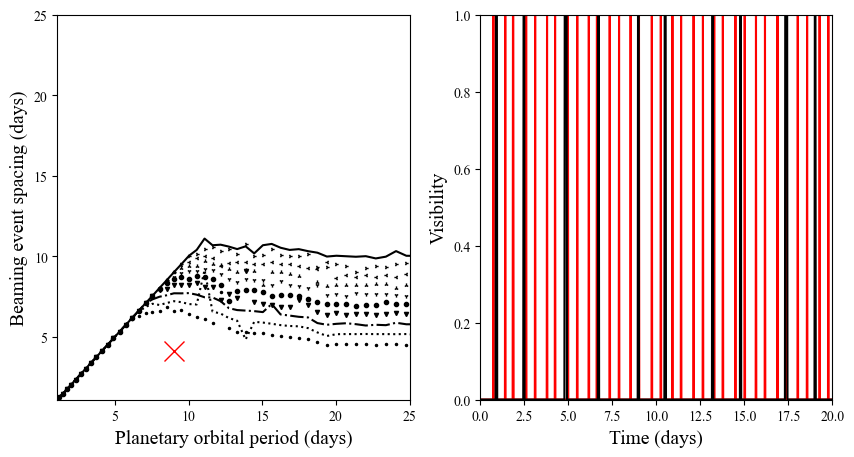

In [124]:
fig, (axs1, axs2) = plt.subplots(1, 2, figsize=(10,5))
color = ["#FF7256", "#6495ED", "orange", "#8470FF", "#33A1C9", "#D02090", "#808069", "#27408B", "#8B3626"]
labels = ["$P_s$ = 2.43", "$P_s$ = 4.17", "$P_s$ = 5.90", "$P_s$ = 7.64", "$P_s$ = 9.37", "$P_s$ = 11.11", "$P_s$ = 12.84", "$P_s$ = 14.58", "$P_s$ = 16.32", "$P_s$ = 18.05"]
marker = [".", ":", "-.", "v", "o", "1", "2", "3", "4", "-"]

test_pp = pp[0]
test_ps = stellar_period[0]
test_a =  (G*M_s*Msun*(test_pp*sec_per_day)**2/(4*np.pi**2))**(1/3) / (R_s*Rsun)


good_pp = pp[9]
good_ps = stellar_period[0]
good_a =  (G*M_s*Msun*(good_pp*sec_per_day)**2/(4*np.pi**2))**(1/3) / (R_s*Rsun)

visN, visS = ms.maser(M_s, R_s, good_ps, i_s, B_s, beta, phi_s0, good_a, i_p, lam, phi_p0, f, alpha, dalpha, times)
visN2, visS2 = ms.maser(M_s, R_s, test_ps, i_s, B_s, beta, phi_s0, test_a, i_p, lam, phi_p0, f, alpha, dalpha, times)



for i in range(0,10):
    axs1.plot(pp, mean_spacing_grid_2[i,:,0], marker[i], c='k', markersize=3, label=labels[i])
axs1.set_xlabel('Planetary orbital period (days)', fontsize=14)
axs1.plot(9, mean_spacing_grid_2[9,9,0], marker='x', c='r', markersize=15)
axs1.set_ylabel('Beaming event spacing (days)', fontsize=14)
#ax1.minorticks_on()
#ax1.legend(framealpha=0, fontsize=14)
axs1.set_ylim(1.1,25)
axs1.set_xlim(1.1,25)
axs2.plot(times, visN2, 'r')
axs2.plot(times, visN, 'k')
axs2.set_xlabel('Time (days)', fontsize=14)
axs2.set_ylabel('Visibility', fontsize=14)


# rect = plt.Rectangle((0.7, 0), 1.3, 1, edgecolor='purple', facecolor='purple', alpha=0.5, label='Beaming event spacing (days)')
# axs[0,0].plot(times, visibility_South, 'k', label='Resolution')
# axs[0,0].plot(xs,ys, 'ro:', markersize=4, label='Relative pair spacing (days)')
# axs[0,0].gca().add_patch(rect)
# axs[0,0].set_xlabel('Time (days)', fontsize=12)
# axs[0,0].set_ylabel('Visibility', fontsize=12)
# axs[0,0].set_xlim(0,20)
# axs[0,0].set_legend(loc='lower right', framealpha=1)



# ax1.set_yticks(fontsize=14)
# ax1.set_xticks(fontsize=14)
# ax2.set_yticks(fontsize=14)
# ax2.set_xticks(fontsize=14)
axs2.set_xlim(0,20)
axs2.set_ylim(0,1)
#ax2.minorticks_on()
plt.show()

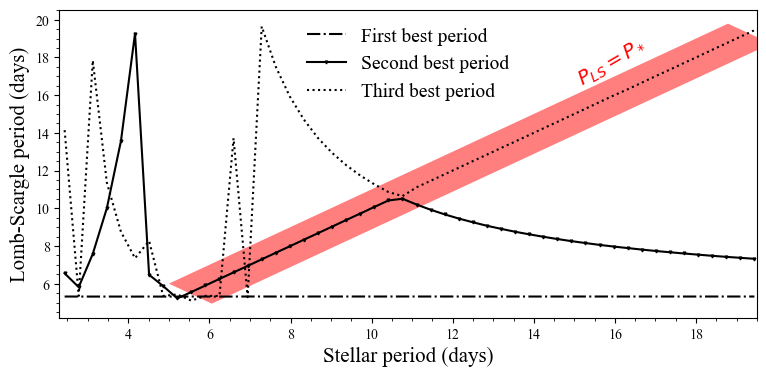

In [125]:
fig = plt.subplots(figsize=(9, 4))

COLOR_PERIOD = "#69b3a2"
COLOR_SPACING = "#3399e6"
from matplotlib.patches import Rectangle
plt.gca().add_patch(Rectangle((5, 6), 1.5, 19.5, edgecolor='none', angle=-45, facecolor='red', fill=True, alpha=0.5))

plt.text(15, 16.5, "$P_{LS} = P_*$", fontsize=14, color='red', rotation=30)

plt.plot(stellar_period, best_period_grid_2[:,12,0], 'k-.', markersize=2, label='First best period')
plt.plot(stellar_period, 1/second_best_period_grid[:,12,0], 'kv-', markersize=2, label='Second best period')
plt.plot(stellar_period, 1/third_best_period_grid[:,12,0], 'k:', markersize=4, label='Third best period')

plt.ylabel("Lomb-Scargle period (days)", fontsize=15)
plt.xlabel("Stellar period (days)", fontsize=15)

plt.xlim(2.3,19.5)
plt.legend(framealpha=0, fontsize=14, loc='upper center')
plt.minorticks_on()
plt.show()



# color = ["pink", "g", "b", "k", "b", "#FF7256", "k", "c", "y", "o", "#6495ED", "g", "b", "o", "b", "orange", "k", "c", "y", "o", "#8470FF", "g", "b", "r", "b", "#33A1C9", "k", "c", "y", "o", "#D02090", "g", "b", "r", "b", "#808069", "k", "c", "y", "o", "#27408B", "g", "b", "r", "b", "#8B3626", "k", "c", "y", "o"]
# labels = ["$P_s$ = 2.43", "g", "b", "k", "b", "$P_s$ = 4.17", "k", "c", "y", "o", "$P_s$ = 5.90", "g", "b", "o", "b", "$P_s$ = 7.64", "k", "c", "y", "o", "$P_s$ = 9.37", "g", "b", "r", "b", "$P_s$ = 11.11", "k", "c", "y", "o", "$P_s$ = 12.84", "g", "b", "r", "b", "$P_s$ = 14.58", "k", "c", "y", "o", "$P_s$ = 16.32", "g", "b", "r", "b", "$P_s$ = 18.05", "k", "c", "y", "o"]
# marker = [".", "g", "b", "k", "b", "#FF7256", "k", "c", "y", "o", ":", "g", "b", "o", "b", "orange", "k", "c", "y", "o", "-.", "g", "b", "r", "b", "#33A1C9", "k", "c", "y", "o", "v", "g", "b", "r", "b", "#808069", "k", "c", "y", "o", "#27408B", "g", "b", "r", "b", "#8B3626", "k", "c", "y", "o"]


# test_pp = pp[23]
# test_ps = stellar_period[0]
# test_a =  (G*M_s*Msun*(test_pp*sec_per_day)**2/(4*np.pi**2))**(1/3) / (R_s*Rsun)

# good_pp = pp[5]
# good_ps = stellar_period[0]
# good_a =  (G*M_s*Msun*(good_pp*sec_per_day)**2/(4*np.pi**2))**(1/3) / (R_s*Rsun)


# visN, visS = ms.maser(M_s, R_s, good_ps, i_s, B_s, beta, phi_s0, good_a, i_p, lam, phi_p0, f, alpha, dalpha, times)
# visNtest, visStest = ms.maser(M_s, R_s, test_ps, i_s, B_s, beta, phi_s0, test_a, i_p, lam, phi_p0, f, alpha, dalpha, times)



# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
# for i in range(0,50,10):
#     ax1.plot(pp, mean_spacing_grid_2[i,:,0], marker[i], c='k', markersize=3, label=labels[i])
# ax1.set_xlabel('Planetary orbital period (days)', fontsize=14)
# ax1.plot(23, 5, marker='x', c='r', markersize=15)
# ax1.set_ylabel('Beaming event spacing (days)', fontsize=14)
# #ax1.minorticks_on()
# ax1.legend(framealpha=0, fontsize=14)
# ax1.set_ylim(1.1,25)
# ax1.set_xlim(1.1,25)
# ax2.plot(times, visNtest, 'r')
# ax2.plot(times, visN, 'k')
# ax2.set_xlabel('Time (days)', fontsize=14)
# ax2.set_ylabel('Visibility', fontsize=14)
# ax2.set_xlim(0,20)
# ax2.set_ylim(0,1)
# #ax2.minorticks_on()
# plt.show()




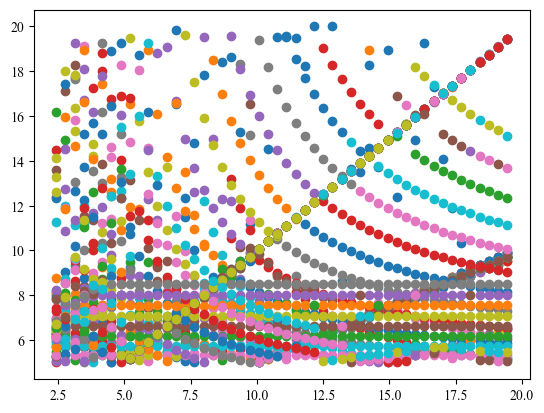

In [585]:

for i in range(0,20):
    plt.scatter(stellar_period, best_period_grid_2[:,i,0])
    plt.scatter(stellar_period, 1/second_best_period_grid[:,i,0])
    plt.scatter(stellar_period, 1/third_best_period_grid[:,i,0])
plt.show()